In [18]:
%load_ext autoreload
%autoreload 2

import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact
import ipywidgets as widgets

from stljax.formula import *
from stljax.viz import *
from stljax.utils import anneal

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

jax.config.update("jax_enable_x64", True)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Generate data

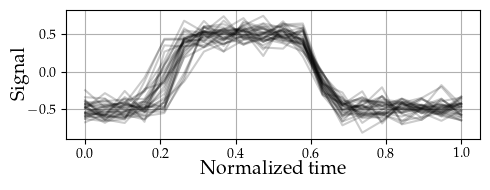

In [19]:
T = 20
fontsize = 14
true_t_start = 0.21
true_t_end = 0.59
bs = 32


key = jax.random.key(1701)
signal_data = jax.vmap(smooth_mask, [None, 0, None, None])(T, true_t_start + 0.02 * jax.random.normal(key, shape=(bs,)), true_t_end, 3.) + jax.random.normal(key, shape=(bs, T,)) * 0.1 - 0.5
plt.figure(figsize=(5,2))
plt.plot(jnp.linspace(0,1,T), signal_data.T, color="black", alpha=0.2)
plt.xlabel("Normalized time", fontsize=fontsize, labelpad=-1)
plt.ylabel("Signal", fontsize=fontsize, labelpad=-1)
plt.grid()
plt.tight_layout()



Define the STL formula with differentiable time intervals and loss function

In [20]:
pred = Predicate('x', lambda x: x)
phi = DifferentiableAlways(pred > 0.)
phi_robustness_jit = jax.jit(phi.robustness, static_argnames=("approx_method"))


@functools.partial(jax.jit, static_argnames=("approx_method"))
def loss(signal_data, t_start, t_end, scale, approx_method, temperature, coeff):
    rob_partial = functools.partial(phi_robustness_jit, t_start=t_start, t_end=t_end, scale=scale, approx_method=approx_method, temperature=temperature)
    robustness_ = jax.vmap(rob_partial, [0])(signal_data)
    robustness = jax.nn.relu(-jnp.where(t_start < (t_end - 0.05), robustness_, jnp.nan)).mean()
    return robustness + coeff * (t_start - t_end)


grad_loss = jax.jit(jax.grad(loss, [1,2]), static_argnames=("approx_method"))


Set up gradient descent routine. 

In [21]:
approx_method = "logsumexp"
temperature = 1.
scale = 1.
a = -2.
b = 2.
lr = 1E-2
max_steps = 5000
scale_start = 0.1
scale_end = 20
temperature_start = 0.1
temperature_end = 20
a_list = [a]
b_list = [b]
coeff_start = 0.1
coeff_end = 0.

# Gradient descent!
for i in range(max_steps):
    j = (i / max_steps)
    s = (1 - j) * scale_start + j * scale_end
    t = (1 - j) * temperature_start + j * temperature_end
    c = (1 - j) * coeff_start + j * coeff_end
    a_ = jax.nn.sigmoid(a)
    b_ = jax.nn.sigmoid(b)
    g = grad_loss(signal_data, a_, b_, s, approx_method, t, c)
    a -= lr * g[0] * a_ * (1 - a_)
    b -= lr * g[1] * b_ * (1 - b_)
    a_list.append(a)
    b_list.append(b)
    # print(a,b)
a_list = jnp.stack(a_list)
b_list = jnp.stack(b_list)

In [22]:
step_size = 50
coeff = 0.1

def visualize_loss_landscape(loss_func, signal, scale, approx_method, temperature, coeff):
    N = 100
    fontsize = 14
    levels = 10
    T = signal.shape[0]
    starts, ends = jnp.meshgrid(jnp.linspace(0,1, N), jnp.linspace(0,1, N))
    losses = jax.vmap(loss_func, [None, 0, 0, None, None, None, None])(signal, starts.reshape([-1,1]), ends.reshape([-1,1]), scale, approx_method, temperature, coeff).reshape([N,N])
    
    plt.contourf(starts, ends, losses, levels=levels, cmap="jet", alpha=0.4)
    plt.colorbar()
    if approx_method != "true":
        match approx_method:
            case "logsumexp":
                app = "LSE"
            case "softmax":
                app = "soft"
        plt.title("Loss landscape \n  (c = %.2f, $\\tau_\\mathrm{%s}$ = %.2f)"%(scale, app, temperature))
    else:
        plt.title("Loss landscape \n (c = %.2f)"%(scale))
    plt.xlabel("$a$", fontsize=fontsize, labelpad=-3)
    plt.ylabel("$b$", fontsize=fontsize, labelpad=-3)
    plt.grid(zorder=-5, alpha=0.2)
    
    
def visualize_results(i, approx_method):
    a, b = jax.nn.sigmoid(a_list[i]), jax.nn.sigmoid(b_list[i])
    j = (i / max_steps)
    s = (1 - j) * scale_start + j * scale_end
    t = (1 - j) * temperature_start + j * temperature_end
    ell = loss(signal_data, a, b, s, approx_method, t, coeff)
    
    # plt.figure(figsize=(4,3))
    
    visualize_loss_landscape(loss, signal_data, s, approx_method, t, coeff)
    plt.plot(jax.nn.sigmoid(a_list[::step_size]), jax.nn.sigmoid(b_list[::step_size]), "o-", markersize=3, color="black", linewidth=1)
    current_loss = loss(signal_data, a, b, s, approx_method, t, coeff)
    gt_loss = loss(signal_data, true_t_start, true_t_end, s, approx_method, t, coeff)
    plt.scatter([a], [b], marker="o", s=40, color="magenta", label="Current: %.3f"%current_loss, edgecolor="black", zorder=4)
    plt.scatter([true_t_start], [true_t_end], marker="*", s=100, color="orange", label="Ground truth: %.3f"%gt_loss, edgecolor="black", zorder=4)
    

    plt.vlines(a, 0, 1, color="red", linestyle='--')
    plt.hlines(b, 0, 1, color="blue", linestyle='--')
    if approx_method != "true":
        match approx_method:
            case "logsumexp":
                app = "LSE"
            case "softmax":
                app = "soft"
        plt.title("Loss = %.5f (c = %.2f, $\\tau_\\mathrm{%s}$ = %.2f)"%(ell, s, app, t))
    else:
        plt.title("Loss = %.5f (c = %.2f)"%(ell, s))
    plt.legend(loc="lower right")


In [23]:
index_slider = widgets.IntSlider(value=0, min=0, max=max_steps-1, step=step_size, description='i: ')
interact(visualize_results, i=index_slider, approx_method=widgets.fixed(approx_method))



interactive(children=(IntSlider(value=0, description='i: ', max=4999, step=50), Output()), _dom_classes=('widg…

<function __main__.visualize_results(i, approx_method)>